In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import psth 

# Load data

In [2]:
import scipy.io
path_to_data = '/Volumes/JUICE/lab projects/spykes_example_data/reaching_example.mat'
#path_to_data = '../data/reaching_example.mat'
mat = scipy.io.loadmat(path_to_data)


# Let's visualize PSTHs aligned to *events* and separated by *conditions*

## Get spike times

In [3]:
area = [i[0] for i in mat['Spikes']['area'][0]]
PMd_loc = [i for i, x in enumerate(area) if x == "PMd"]
M1_loc = [i for i, x in enumerate(area) if x == "M1"]
PMd_neurons = [spks for i, spks in enumerate(mat['Spikes']['times'][0]) if i in PMd_loc]
M1_neurons = [spks for i, spks in enumerate(mat['Spikes']['times'][0]) if i in M1_loc]

## Get event times

In [4]:
events = dict()
events['targetOnTime'] = mat['CenterOutTrial']['TargetOnTime'][0][0]
events['goCueTime'] = mat['CenterOutTrial']['GoCueTime'][0][0]
events['rewardTime'] = mat['CenterOutTrial']['RewardTime'][0][0]

## Get features

In [5]:
features = dict()
features['endpointOfReach'] = mat['CenterOutTrial']['ReachPosition'][0][0]*180/np.pi
features['reward'] = mat['CenterOutTrial']['Reward'][0][0]

## Define conditions based on endpoint of reach

In [6]:
conditions_by_reach = dict()

conditions_by_reach[0] = dict()
conditions_by_reach[0]['endpointOfReach'] = [0, 90]

conditions_by_reach[1] = dict()
conditions_by_reach[1]['endpointOfReach'] = [90, 180]

conditions_by_reach[2] = dict()
conditions_by_reach[2]['endpointOfReach'] = [180, 270]

conditions_by_reach[3] = dict()
conditions_by_reach[3]['endpointOfReach'] = [270, 360]

condition_names = [str(conditions_by_reach[i]['endpointOfReach']) for i in conditions_by_reach]

## PSTH for an example PMd neuron aligned to target onset

In [7]:
neuron_number = 91
spike_times = PMd_neurons[neuron_number-1]
neuron_PMd = psth.PSTH(spike_times, name = 'PMd %d' % neuron_number)

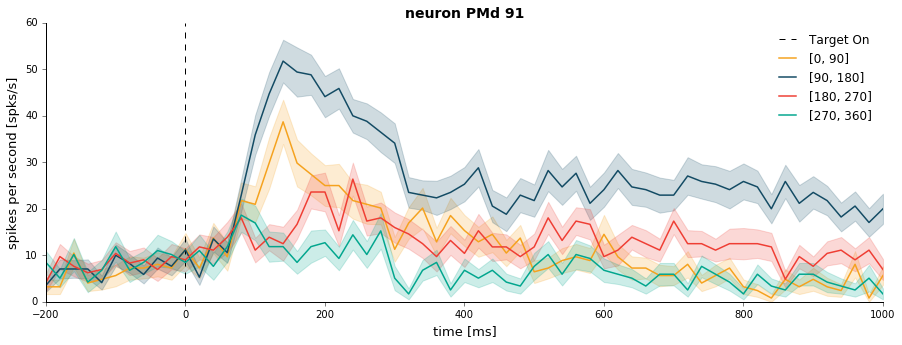

In [8]:
psth_PMd = neuron_PMd.get_psth(events=events['targetOnTime'],
                               features=features,
                               conditions=conditions_by_reach,
                               window=[-200,1000],
                               binsize=20, 
                               plot=False);

neuron_PMd.plot_psth(psth=psth_PMd,
                     figsize=(15,5),
                     event_name='Target On',
                     condition_names=condition_names,
                     ylim=[0,60]);

## Rasters for the same neuron and conditions

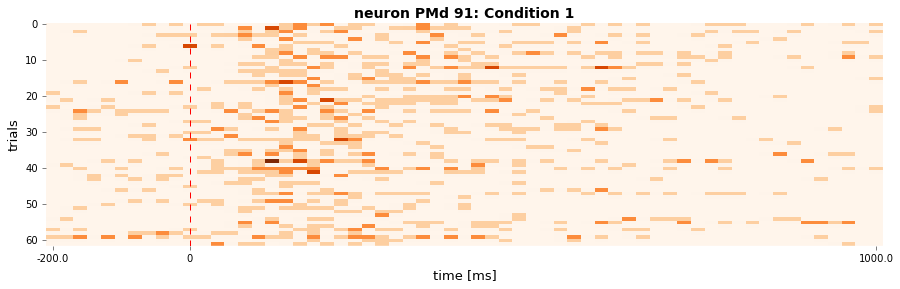

Condition 1: {'endpointOfReach': [0, 90]}


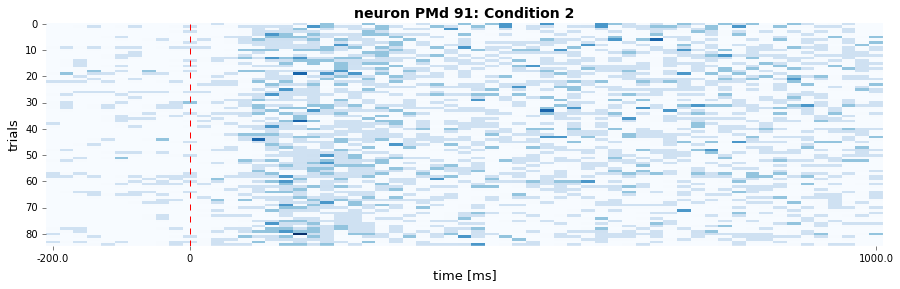

Condition 2: {'endpointOfReach': [90, 180]}


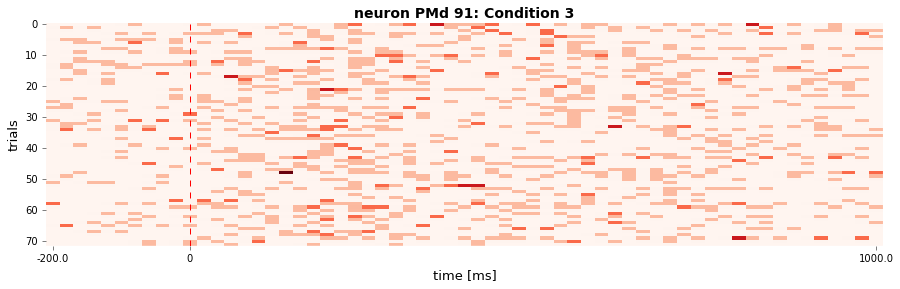

Condition 3: {'endpointOfReach': [180, 270]}


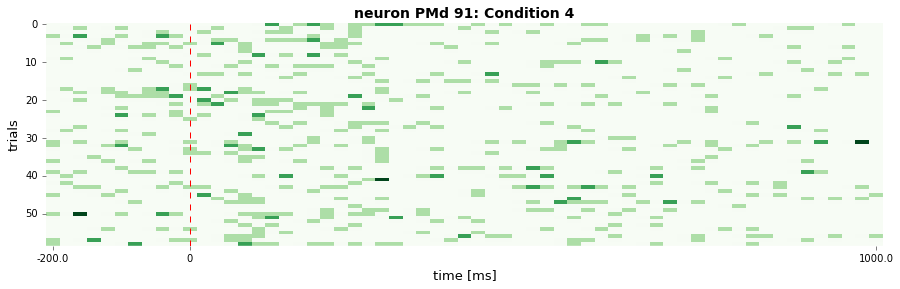

Condition 4: {'endpointOfReach': [270, 360]}


In [21]:
rasters_PMd = neuron_PMd.get_raster(events=events['targetOnTime'],
                               features=features,
                               conditions=conditions_by_reach,
                               window=[-200,1000],
                               binsize=20,
                               plot = False);

neuron_PMd.plot_raster(rasters_PMd,
                      cmap = ['Oranges','Blues','Reds','Greens'],
                      figsize=(15,4))

## PSTH for an example M1 neuron aligned to GO cue

In [14]:
neuron_number = 100
spike_times = M1_neurons[neuron_number-1]
neuron_M1 = psth.PSTH(spike_times, name = 'M1 %d' % neuron_number)

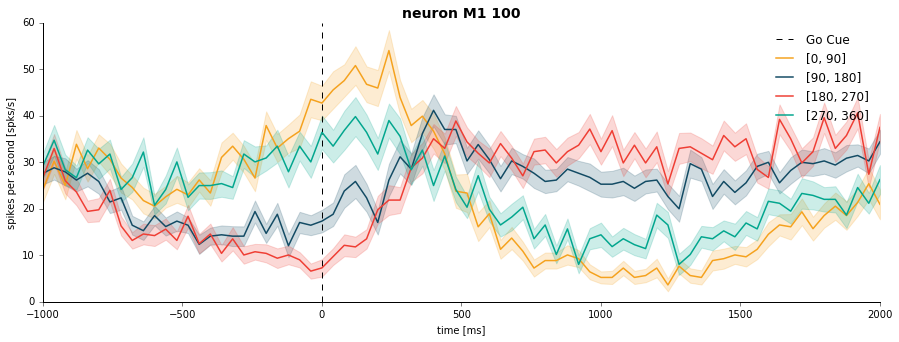

In [15]:
psth_M1 = neuron_M1.get_psth(events=events['goCueTime'],
                             features=features,
                             conditions=conditions_by_reach,
                             window=[-1000,2000],
                             binsize=40,
                             plot=False);

neuron_M1.plot_psth(psth=psth_M1,
                    figsize=(15,5),
                    event_name='Go Cue',
                    condition_names=condition_names,
                    ylim=[0,60]);

## Define conditions based on reward

In [16]:
conditions_by_reward = dict()

conditions_by_reward[0] = dict()
conditions_by_reward[0]['reward'] = [34]

conditions_by_reward[1] = dict()
conditions_by_reward[1]['reward'] = [32]

## PSTH for an example M1 neuron aligned to reward

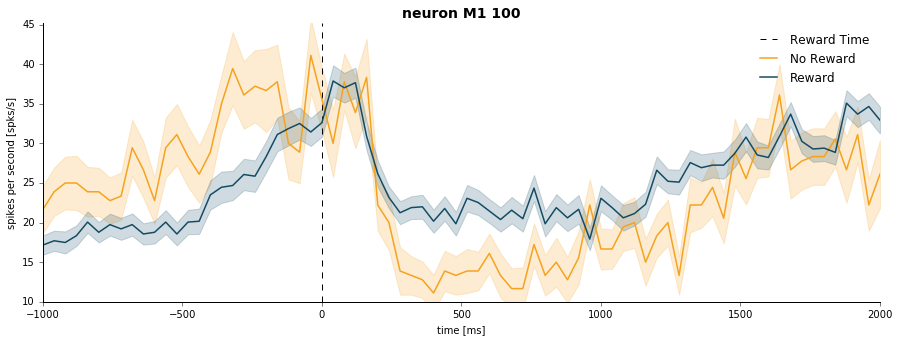

In [17]:
psth_M1 = neuron_M1.get_psth(events=events['rewardTime'],
                            features=features,
                            conditions=conditions_by_reward,
                            window=[-1000,2000],
                            binsize=40,
                            plot=False);

neuron_M1.plot_psth(psth=psth_M1,
                    figsize=(15,5),
                    event_name='Reward Time',
                    condition_names=['No Reward','Reward']);

# Let's fit tuning curves to the population

In [18]:
from neuropop import NeuroPop

## Extract PMd spike counts $\mathbf{Y}$ and reach direction $x$

In [19]:
# Select only high firing rate neurons
PMd_select = list()
threshold = 5.0

# Specify a window of interest around the target onset
window = [0.4, 0.8] # seconds

# Get reach direction
x = np.arctan2(np.sin(features['endpointOfReach']*np.pi/180.0),
               np.cos(features['endpointOfReach']*np.pi/180.0))

# Get spike counts
Y = np.zeros([x.shape[0], len(PMd_neurons)])
for n in range(len(PMd_neurons)):
    this_neuron = psth.PSTH(spiketimes = PMd_neurons[n])
    Y[:, n] = np.squeeze(this_neuron.get_spikecounts(events=events['targetOnTime'], 
                                                     window=window))

    # Short list a few high-firing PMd neurons
    if this_neuron.firingrate > threshold:
        PMd_select.append(n)

# Rescale spike counts to units of spikes/s
Y = Y/(window[1]-window[0])

In [20]:
# Initialize a population instance
pop = NeuroPop(n_neurons=len(PMd_select), 
               tunemodel='georgopulos', 
               fit_k=True, 
               n_repeats=3,
               learning_rate=1e-2,
               verbose=False)

## Fit tuning curves

In [21]:
pop.fit(np.squeeze(x), Y[:, PMd_select])

## Predict firing rates

In [22]:
Yhat = pop.predict(np.squeeze(x))

## Visualize tuning curves

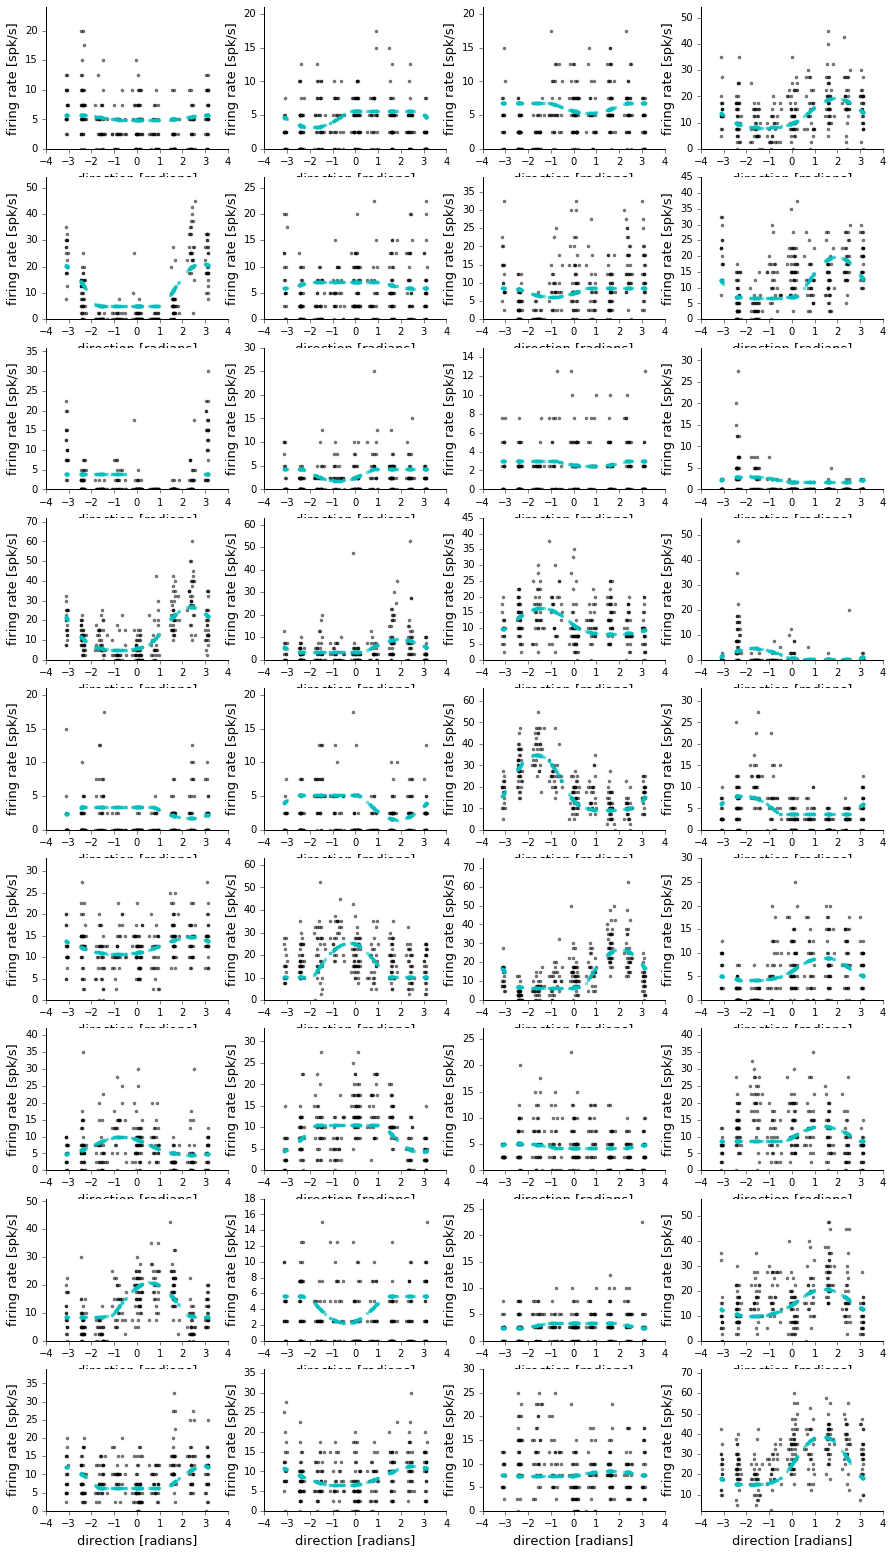

In [23]:
plt.figure(figsize=[15,30])

for neuron in range(len(PMd_select)):
    plt.subplot(10,4,neuron+1)
    pop.display(x, Y[:, PMd_select[neuron]], Yhat[:, neuron], 
                ylim=[0.8*np.min(Y[:, PMd_select[neuron]]), 1.2*np.max(Y[:, PMd_select[neuron]])])
    #plt.axis('off')

plt.show()

## Decode reach direction from population vector

In [19]:
xhat = pop.decode(Y[:, PMd_select])

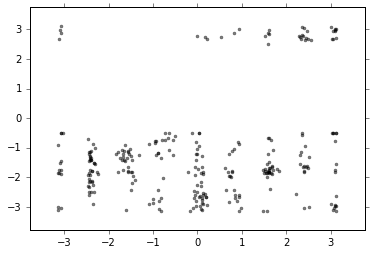

In [20]:
plt.plot(x, xhat, 'k.', alpha=0.5)
plt.xlim([-1.2*np.pi, 1.2*np.pi])
plt.ylim([-1.2*np.pi, 1.2*np.pi])
plt.show()

In [21]:
from scipy import stats
def circ_corr(alpha1, alpha2):
    alpha1_bar = stats.circmean(alpha1)
    alpha2_bar = stats.circmean(alpha2)
    num = np.sum(np.sin(alpha1 - alpha1_bar) * np.sin(alpha2 - alpha2_bar));
    den = np.sqrt(np.sum(np.sin(alpha1 - alpha1_bar) ** 2) * np.sum(np.sin(alpha2 - alpha2_bar) ** 2));
    rho = num / den
    return rho

In [22]:
circ_corr(x, xhat)

9.6313236759663583e-17